In [1]:
# Importing packages
import pandas as pd # for dataframes
import numpy as np # for arrays
import matplotlib.pyplot as plt # for visualizations
import seaborn as sns # also for visualizations
from datetime import date # for transforming the date feature into time series data
import math # for functions

from sklearn.metrics import mean_squared_log_error, mean_squared_error # for evaluations
from sklearn.model_selection import TimeSeriesSplit # for k-fold cross validation
from statistics import mean # for functions

In [2]:
# Establishes a class to represent the nodes and the node's attributes: ID, parent's ID, its given subset of x and y observations, size, depth, and if the node is a leaf node or not
class Node:
    
    def __init__(self, Xsub, ysub, ID, depth = 0, parent_ID = None, leaf = True):
        self.ID = ID
        self.Xsub = Xsub
        self.ysub = ysub
        self.size = len(ysub)
        self.depth = depth
        self.parent_ID = parent_ID
        self.leaf = leaf

# Establishes a class that identifies the best split at the bud. 
class Splitter:
    
    # function that sets itself up in the case of no splitting (leaf node)
    def __init__(self):
        self.rss_reduction = 0
        self.no_split = True # split status
    
    # function to capture the split's reduction in RSS, a variable d that makes the split, the data type, the threshold (to manage overfitting),the L values ( a set of values), and split status
    def _replace_split(self, rss_reduction, d, dtype = 'quant', t = None, L_values = None):
        self.rss_reduction = rss_reduction
        self.d = d # d is the chosen predictor that splits the node
        self.dtype = dtype
        self.t = t # t is the threshold value       
        self.L_values = L_values     
        self.no_split = False # split status

In [3]:
# We build the decision tree using RSS criteria
# Defines a function to determine the best split at each bud
def RSS_criteria(child_L, child_R, parent):
    rss_parent = sum((parent - np.mean(parent))**2)
    rss_child_L = sum((child_L - np.mean(child_L))**2) 
    rss_child_R = sum((child_R - np.mean(child_R))**2)
    return rss_parent - (rss_child_L + rss_child_R) # how much a split reduces the parent node's RSS

# Defines a function that provides a list of unique values in x; used for in spltting
def sorted_x_y(x, y):
    uni_xs = np.unique(x)
    y_mean_for_x = np.array([y[x == uni_x].mean() for uni_x in uni_xs])
    ordered_xs = uni_xs[np.argsort(y_mean_for_x)]
    return ordered_xs

# Defines a function that stop the node from splitting if the training observations are all the same
def equal_rows(X):
    return (X == X[0]).all()

In [4]:
# Establishes the class mainly used to build the model and prediction in the individual decision tree.
class DecisionTreeRegressor:
    
# Training portion
    
    # Fit the data. Uses the provided training data; parameter C is null in the decision tree case
    def fit(self, X, y, max_depth = 100, min_size = 2, C = None):
        
        # Adds the data
        self.X = X
        self.y = y
        self.N, self.D = self.X.shape
        dtypes = [np.array(list(self.X[:,d])).dtype for d in range(self.D)]
        self.dtypes = ['quant' if (dtype == float or dtype == int) else 'cat' for dtype in dtypes] # Differentiates between categorical and numerical variable types
        
        # Adds regularization parameters
        self.max_depth = max_depth
        self.min_size = min_size
        self.C = C
        
        # Initializes the nodes
        self.nodes_dict = {}
        self.current_ID = 0 # Builds node IDs used for building the tree
        root_node = Node(Xsub = X, ysub = y, ID = self.current_ID, parent_ID = None)
        self.nodes_dict[self.current_ID] = root_node
        self.current_ID += 1
        
        # Builds the tree using the _build function below
        self._build()
        
    # Defines the build function for creating decision trees
    def _build(self):
        
        eligible_buds = self.nodes_dict 
        for layer in range(self.max_depth):
            
            # Finds the eligible nodes instantiated above for layer iteration
            eligible_buds = {ID:node for (ID, node) in self.nodes_dict.items() if 
                                (node.leaf == True) &
                                (node.size >= self.min_size) & 
                                (~equal_rows(node.Xsub)) &
                                (len(np.unique(node.ysub)) > 1)}
            if len(eligible_buds) == 0:
                break
                
            # does a split each eligible parent
            for ID, bud in eligible_buds.items():
                                
                # Finds the split
                self._find_split(bud)
                
                # Makes the split
                if not self.splitter.no_split: # provides the possibility of no split
                    self._make_split()
        
    
    # Defines the function for finding the split reduces the bud's RSS
    def _find_split(self, bud):
        
        # Creates the splitter class
        splitter = Splitter()
        splitter.bud_ID = bud.ID
        
        # Based on provided parameter c, this gathers eligible predictors for Random Forests
        if self.C is None:
            eligible_predictors = np.arange(self.D)
        else:
            eligible_predictors = np.random.choice(np.arange(self.D), self.C, replace = False)
        
        # For each eligible predictor
        for d in sorted(eligible_predictors):
            Xsub_d = bud.Xsub[:,d]
            dtype = self.dtypes[d]
            if len(np.unique(Xsub_d)) == 1:
                continue

            # For each threshold value
            if dtype == 'quant': # For quantitative variables
                for t in np.unique(Xsub_d)[:-1]:
                    ysub_L = bud.ysub[Xsub_d <= t]
                    ysub_R = bud.ysub[Xsub_d > t]
                    rss_reduction = RSS_criteria(ysub_L, ysub_R, bud.ysub)
                    if rss_reduction > splitter.rss_reduction:
                        splitter._replace_split(rss_reduction, d, dtype = 'quant', t = t)
            else:
                ordered_x = sorted_x_y(Xsub_d, bud.ysub) # For categorical variables
                for i in range(len(ordered_x) - 1):
                    L_values = ordered_x[:i+1]
                    ysub_L = bud.ysub[np.isin(Xsub_d, L_values)]
                    ysub_R = bud.ysub[~np.isin(Xsub_d, L_values)]
                    rss_reduction = RSS_criteria(ysub_L, ysub_R, bud.ysub)
                    if rss_reduction > splitter.rss_reduction: 
                        splitter._replace_split(rss_reduction, d, dtype = 'cat', L_values = L_values)
        
        # Saves the splitter
        self.splitter = splitter
        
    # Defines the function for making the split. It iterates through the layers of the tree, splits at the eligible nodes, and then repeats.
    def _make_split(self):
        # Updates the parent node
        parent_node = self.nodes_dict[self.splitter.bud_ID]
        parent_node.leaf = False
        parent_node.child_L = self.current_ID
        parent_node.child_R = self.current_ID + 1
        parent_node.d = self.splitter.d
        parent_node.dtype = self.splitter.dtype
        parent_node.t = self.splitter.t        
        parent_node.L_values = self.splitter.L_values
        
        # Get X and y data for children
        if parent_node.dtype == 'quant':
            L_condition = parent_node.Xsub[:,parent_node.d] <= parent_node.t
     
        else:
            L_condition = np.isin(parent_node.Xsub[:,parent_node.d], parent_node.L_values)
        Xchild_L = parent_node.Xsub[L_condition]
        ychild_L = parent_node.ysub[L_condition]
        Xchild_R = parent_node.Xsub[~L_condition]
        ychild_R = parent_node.ysub[~L_condition]

        
        # Creates the child nodes
        child_node_L = Node(Xchild_L, ychild_L, depth = parent_node.depth + 1,
                            ID = self.current_ID, parent_ID = parent_node.ID)
        child_node_R = Node(Xchild_R, ychild_R, depth = parent_node.depth + 1,
                            ID = self.current_ID+1, parent_ID = parent_node.ID)
        self.nodes_dict[self.current_ID] = child_node_L
        self.nodes_dict[self.current_ID + 1] = child_node_R
        self.current_ID += 2
        
    # Prediction portion
    
    # Defines the function _get_leaf_means that calculates the average of the y variable among training observations in each leaf
    def _get_leaf_means(self):
        self.leaf_means = {}
        for node_ID, node in self.nodes_dict.items():
            if node.leaf:
                self.leaf_means[node_ID] = node.ysub.mean()

                
    # Defines the predict function for DecisionTreeRegressor class that runs the test observation through the created tree and returns the mean of the y variable in the leaf
    def predict(self, X_test):
        
        # Calculates the leaf means
        self._get_leaf_means()
     
        yhat = []
        for x in X_test:
            node = self.nodes_dict[0] 
            while not node.leaf:
                if node.dtype == 'quant':
                    if x[node.d] <= node.t:
                        node = self.nodes_dict[node.child_L]
                    else:
                        node = self.nodes_dict[node.child_R]
                else:
                    if x[node.d] in node.L_values:
                        node = self.nodes_dict[node.child_L]
                    else:
                        node = self.nodes_dict[node.child_R]
            yhat.append(self.leaf_means[node.ID])
        return np.array(yhat)

In [5]:
# Defines the class for the Random Forest model
class RandomForest:
    
    # Fit the data 
    def fit(self, X_train, y_train, B, C, max_depth = 100, min_size = 2, seed = None):
        
        # Describes the parameters
        self.X_train = X_train
        self.N, self.D = X_train.shape
        self.y_train = y_train
        self.B = B # This parameter, B, is the number of bootstrapped samples; we build B many trees
        self.C = C # This parameter, C, controls the number of predictors the decision tree considers at each split
        self.seed = seed # Provides the seed for consistent results
        self.trees = [] # Instantiates trees
        
        np.random.seed(seed)
        for b in range(self.B):
            
            sample = np.random.choice(np.arange(self.N), size = self.N, replace = True)
            X_train_b = X_train[sample]
            y_train_b = y_train[sample]
            
            # Uses the DecisionTreeRegressor class to build a single decision tree
            tree = DecisionTreeRegressor()
            tree.fit(X_train_b, y_train_b, max_depth = max_depth, min_size = min_size, C = C)
            self.trees.append(tree) # Appends the trees to create an ensemble
            
    # Defines the predict function for Random Forest    
    def predict(self, X_test):
        
        y_test_hats = np.empty((len(self.trees), len(X_test)))
        for i, tree in enumerate(self.trees):
            y_test_hats[i] = tree.predict(X_test)
        
        
        return y_test_hats.mean(0)

In [6]:
# Loads the data, make sure the csv file is in the same working directory
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [7]:
# Drops the first uknown column in the data
train = train.drop('Unnamed: 0', axis=1)
test = test.drop('Unnamed: 0', axis=1)

In [8]:
# Defines a class, date_to_int, that transforms the Date feature into an integer that represents the days past the initial date found in the data, Jan 21, 2021.
# Transformation of the data for time series analysis
def date_to_int(d):
    initial_date = date(2020, 1, 21)
    curr_date = [int(x) for x in d.split('-')]
    final_date = date(curr_date[0], curr_date[1], curr_date[2])
    delta = final_date - initial_date
    return delta.days

In [9]:
# Transforms the Country feature, a categorical feature, using one-hot encoding into an integer in a vector space representing that respective country
one_hot_train = pd.get_dummies(train['Country'])
train = train.join(one_hot_train)
# Applies the date_to_int function
train['Day'] = train['Date'].apply(lambda x: date_to_int(x))

In [10]:
# Done similarly with test data
one_hot_test = pd.get_dummies(test['Country'])
test = test.join(one_hot_train)
test['Day'] = test['Date'].apply(lambda x: date_to_int(x))

In [11]:
# Applies a log transform on the dependent variables 
train['log_Confirmed'] = train['Confirmed'].apply(lambda x: round(math.log(x+1),3))
train['log_Deaths'] = train['Deaths'].apply(lambda x: round(math.log(x+1),3))
train['log_Recovered'] = train['Recovered'].apply(lambda x: round(math.log(x+1),3))
train['log_Active'] = train['Active'].apply(lambda x: round(math.log(x+1),3))

In [12]:
# Done similarly with test data
test['log_Confirmed'] = test['Confirmed'].apply(lambda x: round(math.log(x+1),3))
test['log_Deaths'] = test['Deaths'].apply(lambda x: round(math.log(x+1),3))
test['log_Recovered'] = test['Recovered'].apply(lambda x: round(math.log(x+1),3))
test['log_Active'] = test['Active'].apply(lambda x: round(math.log(x+1),3))

In [13]:
# Drops the first seven columns in the data set that contained the untransformed features
train.drop(train.iloc[:, 0:6], inplace = True, axis = 1)
test.drop(test.iloc[:, 0:6], inplace = True, axis = 1)

In [18]:
# Grabbing x/y train test sets for 'Confirmed' cases
confirmed_train_x = train.drop(train.columns[[-1,-2,-3,-4]], axis = 1)
confirmed_train_y = train['log_Confirmed']

confirmed_test_x = test.drop(test.columns[[-1,-2,-3,-4]], axis = 1)
confirmed_test_y = test['log_Confirmed']

# Performing 5-fold cross validation on rolling basis for 'Confirmed' RF model
all_train = confirmed_train_x.append(confirmed_test_x).to_numpy()
all_values = confirmed_train_y.append(confirmed_test_y).to_numpy()

tscv = TimeSeriesSplit(n_splits=5)
rmse_scores = []
rmsle_scores = []

for train_index, test_index in tscv.split(all_train):
    X_train, X_test = all_train[train_index], all_train[test_index]
    y_train, y_test = all_values[train_index], all_values[test_index]
    
    rf = RandomForest()
    rf.fit(X_train, y_train, B = 30, C = 4, max_depth = 20, min_size = 5, seed = None)
    predict = rf.predict(X_test)
    rmse_scores.append(round(mean_squared_error(y_test, predict),3))
    rmsle_scores.append(round(mean_squared_log_error(y_test, predict),3))

print('Now predicting Confirmed Cases...')
print('Cross validated root mean squared errors are:', rmse_scores)
print('Average RMSE using RF to predict Confirmed cases is:', mean(rmse_scores))
print()
print('Cross validated root mean squared log errors are:', rmsle_scores)
print('Average RMSLE using RF to predict Confirmed cases is:', mean(rmsle_scores))

Now predicting Confirmed Cases...
Cross validated root mean squared errors are: [0.731, 2.642, 9.513, 17.414, 14.406]
Average RMSE using RF to predict Confirmed cases is: 8.9412

Cross validated root mean squared log errors are: [0.094, 0.292, 0.691, 0.715, 0.361]
Average RMSLE using RF to predict Confirmed cases is: 0.4306


Text(0, 0.5, '$\\hat{y}$')

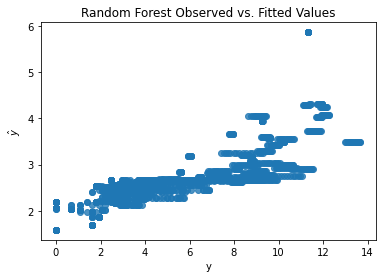

In [15]:
# Plots the observed values, y, against the fittted values, y hat
df_pred = pd.DataFrame(list(y_test), columns = ['y_test'])
df_pred['predict'] = list(predict)

plt.scatter(df_pred['y_test'], df_pred['predict'], alpha = 0.8)
plt.title('Random Forest Observed vs. Fitted Values')
plt.xlabel('y')
plt.ylabel('$\hat{y}$')

In [16]:
df_pred.corr()

,y_test,predict
y_test,1.00000,0.74558
predict,0.74558,1.00000


In [23]:
# Grabbing x/y train test sets for 'Deaths' cases
deaths_train_x = train.drop(train.columns[[-1,-2,-3,-4]], axis = 1)
deaths_train_y = train['log_Deaths']

deaths_test_x = test.drop(test.columns[[-1,-2,-3,-4]], axis = 1)
deaths_test_y = test['log_Deaths']

# Performing 5-fold cross validation on rolling basis for 'Deaths' RF model
all_train = deaths_train_x.append(deaths_test_x).to_numpy()
all_values = deaths_train_y.append(deaths_test_y).to_numpy()

tscv = TimeSeriesSplit(n_splits=5)
rmse_scores = []
rmsle_scores = []

for train_index, test_index in tscv.split(all_train):
    X_train, X_test = all_train[train_index], all_train[test_index]
    y_train, y_test = all_values[train_index], all_values[test_index]
    
    rf = RandomForest()
    rf.fit(X_train, y_train, B = 30, C = 4, max_depth = 20, min_size = 5, seed = None)
    predict = rf.predict(X_test)
    rmse_scores.append(round(mean_squared_error(y_test, predict),3))
    rmsle_scores.append(round(mean_squared_log_error(y_test, predict),3))

print('Now predicting Deaths Cases...')
print('Cross validated root mean squared errors are:', rmse_scores)
print('Average RMSE using RF to predict Deaths cases is:', mean(rmse_scores))
print()
print('Cross validated root mean squared log errors are:', rmsle_scores)
print('Average RMSLE using RF to predict Deaths cases is:', mean(rmsle_scores))

Now predicting Deaths Cases...
Cross validated root mean squared errors are: [0.123, 0.453, 1.825, 5.987, 9.067]
Average RMSE using RF to predict Deaths cases is: 3.491

Cross validated root mean squared log errors are: [0.009, 0.056, 0.245, 0.596, 0.673]
Average RMSLE using RF to predict Deaths cases is: 0.3158


Text(0, 0.5, '$\\hat{y}$')

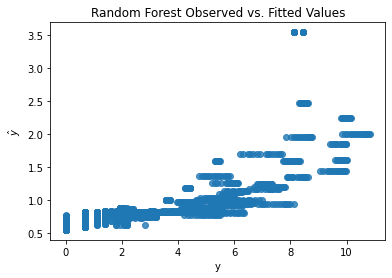

In [18]:
# Plots the observed values, y, against the fittted values, y hat
df_pred = pd.DataFrame(list(y_test), columns = ['y_test'])
df_pred['predict'] = list(predict)

plt.scatter(df_pred['y_test'], df_pred['predict'], alpha = 0.8)
plt.title('Random Forest Observed vs. Fitted Values')
plt.xlabel('y')
plt.ylabel('$\hat{y}$')

In [19]:
df_pred.corr()

,y_test,predict
y_test,1.000000,0.730736
predict,0.730736,1.000000


In [28]:
# Grabbing x/y train test sets for 'Recovered' cases
recovered_train_x = train.drop(train.columns[[-1,-2,-3,-4]], axis = 1)
recovered_train_y = train['log_Recovered']

recovered_test_x = test.drop(test.columns[[-1,-2,-3,-4]], axis = 1)
recovered_test_y = test['log_Recovered']

# Performing 5-fold cross validation on rolling basis for 'Deaths' RF model
all_train = recovered_train_x.append(recovered_test_x).to_numpy()
all_values = recovered_train_y.append(recovered_test_y).to_numpy()

tscv = TimeSeriesSplit(n_splits=5)
rmse_scores = []
rmsle_scores = []

for train_index, test_index in tscv.split(all_train):
    X_train, X_test = all_train[train_index], all_train[test_index]
    y_train, y_test = all_values[train_index], all_values[test_index]
    
    rf = RandomForest()
    rf.fit(X_train, y_train, B = 30, C = 4, max_depth = 20, min_size = 5, seed = None)
    predict = rf.predict(X_test)
    rmse_scores.append(round(mean_squared_error(y_test, predict),3))
    rmsle_scores.append(round(mean_squared_log_error(y_test, predict),3))

print('Now predicting Recovered Cases...')
print('Cross validated root mean squared errors are:', rmse_scores)
print('Average RMSE using RF to predict Recovered cases is:', mean(rmse_scores))
print()
print('Cross validated root mean squared log errors are:', rmsle_scores)
print('Average RMSLE using RF to predict Recovered cases is:', mean(rmsle_scores))

Now predicting Recovered Cases...
Cross validated root mean squared errors are: [0.452, 0.999, 2.634, 9.167, 13.391]
Average RMSE using RF to predict Recovered cases is: 5.3286

Cross validated root mean squared log errors are: [0.066, 0.116, 0.301, 0.788, 0.669]
Average RMSLE using RF to predict Recovered cases is: 0.388


Text(0, 0.5, '$\\hat{y}$')

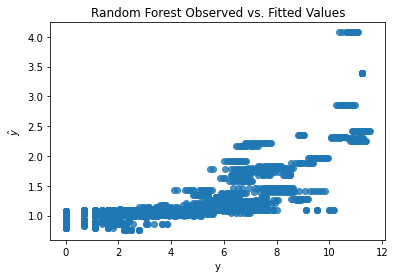

In [21]:
# Plots the observed values, y, against the fittted values, y hat
df_pred = pd.DataFrame(list(y_test), columns = ['y_test'])
df_pred['predict'] = list(predict)

plt.scatter(df_pred['y_test'], df_pred['predict'], alpha = 0.8)
plt.title('Random Forest Observed vs. Fitted Values')
plt.xlabel('y')
plt.ylabel('$\hat{y}$')

In [22]:
df_pred.corr()

,y_test,predict
y_test,1.000000,0.709267
predict,0.709267,1.000000


In [33]:
# Grabbing x/y train test sets for 'Active' cases
active_train_x = train.drop(train.columns[[-1,-2,-3,-4]], axis = 1)
active_train_y = train['log_Active']

active_test_x = test.drop(test.columns[[-1,-2,-3,-4]], axis = 1)
active_test_y = test['log_Active']

# Performing 5-fold cross validation on rolling basis for 'Active' RF model
all_train = recovered_train_x.append(active_test_x).to_numpy()
all_values = recovered_train_y.append(active_test_y).to_numpy()

tscv = TimeSeriesSplit(n_splits=5)
rmse_scores = []
rmsle_scores = []

for train_index, test_index in tscv.split(all_train):
    X_train, X_test = all_train[train_index], all_train[test_index]
    y_train, y_test = all_values[train_index], all_values[test_index]
    
    rf = RandomForest()
    rf.fit(X_train, y_train, B = 30, C = 4, max_depth = 20, min_size = 5, seed = None)
    predict = rf.predict(X_test)
    rmse_scores.append(round(mean_squared_error(y_test, predict),3))
    rmsle_scores.append(round(mean_squared_log_error(y_test, predict),3))

print('Now predicting Active Cases...')
print('Cross validated root mean squared errors are:', rmse_scores)
print('Average RMSE using RF to predict Active cases is:', mean(rmse_scores))
print()
print('Cross validated root mean squared log errors are:', rmsle_scores)
print('Average RMSLE using RF to predict Active cases is:', mean(rmsle_scores))

Now predicting Active Cases...
Cross validated root mean squared errors are: [0.452, 0.93, 11.211, 17.695, 14.343]
Average RMSE using RF to predict Active cases is: 8.9262

Cross validated root mean squared log errors are: [0.067, 0.116, 1.096, 0.801, 0.412]
Average RMSLE using RF to predict Active cases is: 0.4984


Text(0, 0.5, '$\\hat{y}$')

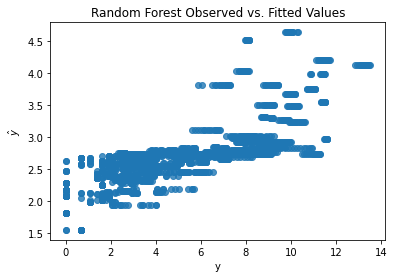

In [24]:
# Plots the observed values, y, against the fittted values, y hat
df_pred = pd.DataFrame(list(y_test), columns = ['y_test'])
df_pred['predict'] = list(predict)

plt.scatter(df_pred['y_test'], df_pred['predict'], alpha = 0.8)
plt.title('Random Forest Observed vs. Fitted Values')
plt.xlabel('y')
plt.ylabel('$\hat{y}$')

In [25]:
df_pred.corr()

,y_test,predict
y_test,1.000000,0.728403
predict,0.728403,1.000000


from sklearn import metrics
mae=metrics.mean_absolute_error(y_test, predict)
mse=metrics.mean_squared_error(y_test, predict)
# Printing the metrics
print('R2 square:',metrics.r2_score(y_test, predict))
print('MAE: ', mae)
print('MSE: ', mse)